In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, PrecisionRecallDisplay, precision_score, recall_score, roc_auc_score, RocCurveDisplay, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from datetime import timedelta
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

In [3]:
# read all tables
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

MERGE DATA

In [4]:
# step 1: marketing data at a customer level
marketing_agg = marketing[marketing['response']=='Yes'].groupby('customer_id')['campaign_id'].count().to_frame()
# step 2: aggregate transaction data at a customer level
transactions_agg = transactions.groupby('customer_id').aggregate({'transaction_id':'count','transaction_amount':'sum'})

In [5]:
# step 3: set customers and engagement index as customer_id
customers.set_index('customer_id', inplace=True)
engagement.set_index('customer_id', inplace=True)
# step 4: join all tables
joint_data = customers.join(engagement).join(transactions_agg).join(marketing_agg)
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN


## DATA CLEANING & FEATURE ENGINEERING

LTV Calculation

In [6]:
# Calculation of LTV
joint_data.groupby('customer_id')['transaction_amount'].sum()
joint_data['LTV'] = joint_data.groupby('customer_id')['transaction_amount'].sum()
joint_data.head()


,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,LTV
customer_id,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0,3509.48
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0,6081.32
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0,1454.87
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0,7874.68
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN,15524.55


In [7]:
joint_data['LTV'].describe()

count    10000.000000
mean      7737.562981
std       4628.799469
min         23.810000
25%       3839.915000
50%       7498.890000
75%      11275.797500
max      24298.220000
Name: LTV, dtype: float64

In [8]:
# 10% of age entries are blank 
null_counts = joint_data['age'].isnull().sum()
null_counts

1009

In [9]:
# Create KNNImputer instance - this is to clean the age data since it will be used in modelling
imputer = KNNImputer(n_neighbors=2)

In [10]:
# Apply the imputer to the age column
joint_data[['age']] = imputer.fit_transform(joint_data[['age']])

In [11]:
joint_data['campaign_id'].value_counts()

campaign_id
1.0    4011
2.0    2563
3.0     923
4.0     168
Name: count, dtype: int64

In [13]:
# over 20% of customers were not sent any marketing campaigns
campaign_null_counts = joint_data['campaign_id'].isnull().sum()
campaign_null_counts

0

In [12]:
# KNN used to make up for the null values
imputer = KNNImputer(n_neighbors=5)
joint_data[['campaign_id']] = imputer.fit_transform(joint_data[['campaign_id']])

In [14]:
# Convert transaction_date to datetime
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

In [15]:
# Customer Join Time (How long they have been a member)
joint_data['Customer_Join_Time'] = pd.to_datetime(joint_data['last_purchase_date']) - pd.to_datetime(joint_data['join_date'])
joint_data['Customer_Join_Time']

customer_id
1       118 days
2       777 days
3       544 days
4       243 days
5       494 days
          ...   
9996    240 days
9997    200 days
9998    135 days
9999     66 days
10000    98 days
Name: Customer_Join_Time, Length: 10000, dtype: timedelta64[ns]

In [16]:
# Avg transaction amount
joint_data['Avg_Transaction_Amount'] = (joint_data['LTV'])/(joint_data['transaction_id'])
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,LTV,Customer_Join_Time,Avg_Transaction_Amount
customer_id,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,1.000000,3509.48,118 days,584.913333
2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,2.000000,6081.32,777 days,675.702222
3,2021-06-01,2022-11-27,43.467467,NaN,North Latoyatown,192,73,25,6,1454.87,1.000000,1454.87,544 days,242.478333
4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,1.000000,7874.68,243 days,393.734000
5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,1.640965,15524.55,494 days,646.856250


In [17]:
# Tier Avg Spend
joint_data['Avg_Spending_Tier'] = pd.qcut(joint_data['Avg_Transaction_Amount'], 3, labels=['low', 'medium', 'high'])

In [18]:
# PREP Avg Spend for CATEGORICAL COLUMN 
def Avg_Spend_Categorical(x):
    if x == 'low':
        return 1
    elif x == 'medium':
        return 2
    elif x == 'high':
        return 3

In [19]:
joint_data['Avg_Spend_Categorical'] = joint_data['Avg_Spending_Tier'].apply(Avg_Spend_Categorical)
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,LTV,Customer_Join_Time,Avg_Transaction_Amount,Avg_Spending_Tier,Avg_Spend_Categorical
customer_id,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,1.000000,3509.48,118 days,584.913333,medium,2
2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,2.000000,6081.32,777 days,675.702222,high,3
3,2021-06-01,2022-11-27,43.467467,NaN,North Latoyatown,192,73,25,6,1454.87,1.000000,1454.87,544 days,242.478333,low,1
4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,1.000000,7874.68,243 days,393.734000,low,1
5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,1.640965,15524.55,494 days,646.856250,medium,2


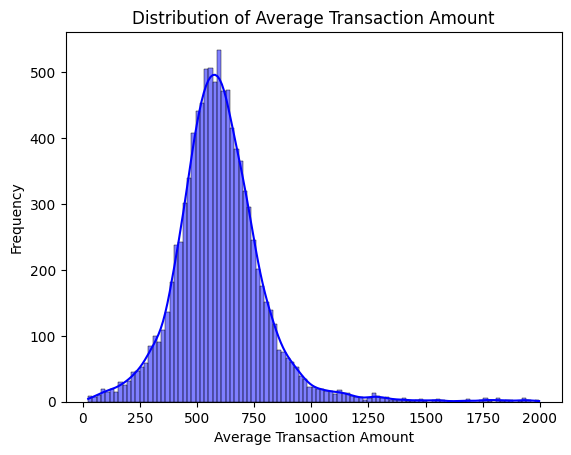

In [20]:
# Histogram to determine data distribution
sns.histplot(joint_data['Avg_Transaction_Amount'], kde=True, color='blue')  # KDE adds a density curve
plt.title('Distribution of Average Transaction Amount')
plt.xlabel('Average Transaction Amount')
plt.ylabel('Frequency')
plt.show()

In [21]:
# Most Recent Purchase (in days)
joint_data['most_recent_purchase_date'] = pd.to_datetime(joint_data['last_purchase_date'].max()) - pd.to_datetime(joint_data['last_purchase_date'])

In [22]:
# convert to an integer number of days for most recent purchase
joint_data['most_recent_purchase_in_days'] = joint_data['most_recent_purchase_date'].dt.days

In [23]:
# convert to an integer number of days for customer age
joint_data['Customer_Jointime_in_days']=joint_data['Customer_Join_Time'].dt.days

In [24]:
# Gender for CATEGORICAL COLUMN 
def Gender_Categorical(x):
    if x == 'Male':
        return 1
    elif x == 'Female':
        return 2
    else:
        return 0

In [25]:
joint_data['Gender_Categorical'] = joint_data['gender'].apply(Gender_Categorical)
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,LTV,Customer_Join_Time,Avg_Transaction_Amount,Avg_Spending_Tier,Avg_Spend_Categorical,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Jointime_in_days,Gender_Categorical
customer_id,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,1.000000,3509.48,118 days,584.913333,medium,2,75 days,75,118,2
2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,2.000000,6081.32,777 days,675.702222,high,3,219 days,219,777,1
3,2021-06-01,2022-11-27,43.467467,NaN,North Latoyatown,192,73,25,6,1454.87,1.000000,1454.87,544 days,242.478333,low,1,551 days,551,544,0
4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,1.000000,7874.68,243 days,393.734000,low,1,638 days,638,243,1
5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,1.640965,15524.55,494 days,646.856250,medium,2,364 days,364,494,1


In [26]:
# Scoring Frequency and Monetary: Higher values are better
joint_data['SiteVisit_Score'] = pd.qcut(joint_data['number_of_site_visits'], 4, labels=[1, 2, 3, 4])
joint_data['EmailOpen_Score'] = pd.qcut(joint_data['number_of_emails_opened'], 4, labels=[1, 2, 3, 4])
joint_data['Click_Score'] = pd.qcut(joint_data['number_of_clicks'], 4, labels=[1, 2, 3, 4])

# Combine scores to a single score
joint_data['Engagement_Score'] = joint_data['SiteVisit_Score'].astype(int) + joint_data['EmailOpen_Score'].astype(int) + joint_data['Click_Score'].astype(int)
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,Avg_Spending_Tier,Avg_Spend_Categorical,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Jointime_in_days,Gender_Categorical,SiteVisit_Score,EmailOpen_Score,Click_Score,Engagement_Score
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,...,medium,2,75 days,75,118,2,1,2,1,4
2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,...,high,3,219 days,219,777,1,4,3,4,11
3,2021-06-01,2022-11-27,43.467467,NaN,North Latoyatown,192,73,25,6,1454.87,...,low,1,551 days,551,544,0,4,4,3,11
4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,...,low,1,638 days,638,243,1,3,3,3,9
5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,...,medium,2,364 days,364,494,1,4,1,2,7


In [27]:
joint_data['Engagement_Score'].describe()

count    10000.00000
mean         7.44240
std          2.89733
min          3.00000
25%          5.00000
50%          8.00000
75%         10.00000
max         12.00000
Name: Engagement_Score, dtype: float64

In [28]:
# PREP Engagement for CATEGORICAL COLUMN 
def Engage_Categorical(x):
    if x <=5:
        return 1
    elif x <=8:
        return 2
    elif x >= 10:
        return 3
    else:
        return 0

In [29]:
joint_data['Engage_Categorical'] = joint_data['Engagement_Score'].apply(Engage_Categorical)
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,Avg_Spend_Categorical,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Jointime_in_days,Gender_Categorical,SiteVisit_Score,EmailOpen_Score,Click_Score,Engagement_Score,Engage_Categorical
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,...,2,75 days,75,118,2,1,2,1,4,1
2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,...,3,219 days,219,777,1,4,3,4,11,3
3,2021-06-01,2022-11-27,43.467467,NaN,North Latoyatown,192,73,25,6,1454.87,...,1,551 days,551,544,0,4,4,3,11,3
4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,...,1,638 days,638,243,1,3,3,3,9,0
5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,...,2,364 days,364,494,1,4,1,2,7,2


In [30]:
# Avg Transaction Time = how often do they make a transaction (in days)
joint_data['Avg_Transaction_Time'] = joint_data['Customer_Jointime_in_days']/joint_data['transaction_id']
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Jointime_in_days,Gender_Categorical,SiteVisit_Score,EmailOpen_Score,Click_Score,Engagement_Score,Engage_Categorical,Avg_Transaction_Time
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,...,75 days,75,118,2,1,2,1,4,1,19.666667
2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,...,219 days,219,777,1,4,3,4,11,3,86.333333
3,2021-06-01,2022-11-27,43.467467,NaN,North Latoyatown,192,73,25,6,1454.87,...,551 days,551,544,0,4,4,3,11,3,90.666667
4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,...,638 days,638,243,1,3,3,3,9,0,12.150000
5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,...,364 days,364,494,1,4,1,2,7,2,20.583333


In [31]:
joint_data['location'].value_counts()

location
Lake James           15
North Christopher    12
Port John            11
West David           11
New John             10
                     ..
Adamstown             1
Lake Deborahburgh     1
New Joanna            1
New Lynnburgh         1
Hollytown             1
Name: count, Length: 7695, dtype: int64

In [700]:
# Create the LabelEncoder instance
label_encoder = LabelEncoder()

In [701]:
# Fit and transform the data
joint_data['location_encoded'] = label_encoder.fit_transform(joint_data['location'])

In [702]:
# Convert the encoded integers to floats
joint_data['location_encoded'] = joint_data['location_encoded'].astype(float)
# it was found that this hurt when inserted as an input variable for all of the models as the accuracy scores for '1' were
# well under 0.7

In [32]:
# Convert the 'date' column to datetime type
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

## MODEL BUILDING AND EVALUATION

3 MONTHS RF - LOGISTICAL REGRESSION (THIS WAS CHOSEN AS THE MDOEL OF CHOICE FOR RF)

In [33]:
# 75th percentile or better for the joint_data['LTV'] is used for binary output because we are trying to predict the highest value customers
# and this is reflective of the highest $$$ value customers over the lifetime of transactions
joint_data['binary_output'] = joint_data['LTV'].apply(lambda x: 1 if x>=11275.797500 else 0)
joint_data['binary_output'].value_counts()

binary_output
0    7500
1    2500
Name: count, dtype: int64

In [34]:
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,most_recent_purchase_in_days,Customer_Jointime_in_days,Gender_Categorical,SiteVisit_Score,EmailOpen_Score,Click_Score,Engagement_Score,Engage_Categorical,Avg_Transaction_Time,binary_output
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,...,75,118,2,1,2,1,4,1,19.666667,0
2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,...,219,777,1,4,3,4,11,3,86.333333,0
3,2021-06-01,2022-11-27,43.467467,NaN,North Latoyatown,192,73,25,6,1454.87,...,551,544,0,4,4,3,11,3,90.666667,0
4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,...,638,243,1,3,3,3,9,0,12.150000,0
5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,...,364,494,1,4,1,2,7,2,20.583333,1


In [35]:
# This model will predict whether there will be a large amount of high value customers 
X_JD = joint_data[['age','Customer_Jointime_in_days', 'Engage_Categorical', 'Gender_Categorical', 
              'Avg_Transaction_Time', 'campaign_id', 'most_recent_purchase_in_days']]
y_JD = joint_data['binary_output']

In [36]:
# reserve 30% for testing
X_train_JD, X_test_JD, y_train_JD, y_test_JD = train_test_split(X_JD,y_JD, test_size=0.3, random_state=42)

In [37]:
# build our pipeline that includes these transformations
numeric_columns_JD = ['age','Customer_Jointime_in_days', 'Avg_Transaction_Time', 'campaign_id',
                      'most_recent_purchase_in_days' ]
categorical_columns_JD = ['Engage_Categorical', 'Gender_Categorical']

In [38]:
# create a pre-processing pipeline which includes the steps of Scaling numeric variables and encoding categoricals
preprocessor_JD = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns_JD),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_columns_JD)
    ]
)

In [39]:
# test 3 models with cross validation to see which ones work best for this data
knn_JD = KNeighborsClassifier()
logreg_JD = LogisticRegression()
nb_JD = GaussianNB()

In [41]:
# cross validation to determine in general which model works best for the given problem
knn_scores_JD = cross_val_score(knn_JD, X_train_JD, y_train_JD, scoring='f1', cv=5)
logreg_scores_JD = cross_val_score(logreg_JD, X_train_JD, y_train_JD, scoring='f1', cv=5)
nb_scores_JD = cross_val_score(nb_JD, X_train_JD, y_train_JD, scoring='f1', cv=5)
print(f"knn_scores_JD: {np.mean(knn_scores_JD)}")
print(f"logreg_scores_JD: {np.mean(logreg_scores_JD)}")
print(f"nb_scores_JD: {np.mean(nb_scores_JD)}")

# KNN ruled out because it has lowest score Logreg will be put through the pipeline

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

knn_scores_JD: 0.38728121040171837
logreg_scores_JD: 0.6635822077985828
nb_scores_JD: 0.4879213155784572


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
# build our pipeline
pipeline_JD = Pipeline(steps=[
    ('preprocessor', preprocessor_JD),
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs'))])

In [43]:
# use GRID SEARCH to find the best combination of hyperparameters for our problem
param_grid_JD = {
  'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algorithms to use in the optimization problem
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Norm used in the penalization
    'classifier__max_iter': [100, 200, 300]  # Maximum number of iterations taken for the solvers to converge
}

In [44]:
grid_search_JD = GridSearchCV(pipeline_JD, param_grid_JD, cv=5, verbose=1, scoring='f1')
grid_search_JD.fit(X_train_JD,y_train_JD)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['age',
                                                                          'Customer_Jointime_in_days',
                                                                          'Avg_Transaction_Time',
                                                                          'campaign_id',
                                                                          'most_recent_purchase_in_days']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Engage_Categorical',
                                                                          'Gender_Categorical'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__max_iter': [100, 200, 300],
                         'classifier__penalty': ['l1', 'l2', 'elasticnet',
                                                 'none'],
                         'classifier__solver': ['newton-cg', 'lbfgs',
                                                'liblinear', 'sag', 'saga']},
             scoring='f1', verbose=1)

In [45]:
final_classifier_JD = LogisticRegression(
    C=grid_search_JD.best_params_['classifier__C'],
    solver=grid_search_JD.best_params_['classifier__solver'],
    penalty=grid_search_JD.best_params_['classifier__penalty'],
    max_iter=grid_search_JD.best_params_['classifier__max_iter']
)

In [46]:
final_pipeline_JD = Pipeline(steps=
                          [
                              ('preprocessor',preprocessor_JD),
                              ('classifier',final_classifier_JD)
                          ])

In [47]:
final_pipeline_JD.fit(X_train_JD,y_train_JD)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['age',
                                                   'Customer_Jointime_in_days',
                                                   'Avg_Transaction_Time',
                                                   'campaign_id',
                                                   'most_recent_purchase_in_days']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Engage_Categorical',
                                                   'Gender_Categorical'])])),
                ('classifier',
                 LogisticRegression(C=100, max_iter=200, penalty='l1',
                                    solver='liblinear'))])

In [48]:
pred_JD = final_pipeline_JD.predict(X_test_JD)
probs_JD = final_pipeline_JD.predict_proba(X_test_JD)

In [49]:
# F1 Scores for KNN, LogReg, and NB - Using RF Scores over 6 month period (before building pipeline and using GridSearch)
# Logreg chosen due to having highest score
report_JD = classification_report(y_test_JD, pred_JD)
print(report_JD)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2263
           1       0.76      0.60      0.67       737

    accuracy                           0.86      3000
   macro avg       0.82      0.77      0.79      3000
weighted avg       0.85      0.86      0.85      3000



RandomForestRegressor - 3 MONTH RF

In [50]:
# Create a RandomForestRegressor object
model_JDRFR = RandomForestRegressor(n_estimators=100, random_state=42)

# Splitting the data into training and testing sets
X_train_JDRFR, X_test_JDRFR, y_train_JDRFR, y_test_JDRFR = train_test_split(X_JD, y_JD, test_size=0.3, random_state=42)

In [51]:
# Fit the model to the training data
model_JDRFR.fit(X_train_JDRFR, y_train_JDRFR)

RandomForestRegressor(random_state=42)

In [52]:
y_pred_JDRFR= model_JDRFR.predict(X_test_JDRFR)
y_pred_JDRFR

array([0.  , 0.18, 0.  , ..., 0.02, 0.01, 0.8 ])

In [53]:
# Convert predictions to binary by applying a threshold
threshold_JDRFR = 0.5
y_pred_binary_JDRFR = (y_pred_JDRFR > threshold_JDRFR).astype(int)
#  RandomForestRegressor Scores - Using RF Scores over 3 month period
print(classification_report(y_test_JDRFR, y_pred_binary_JDRFR))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2263
           1       0.73      0.72      0.72       737

    accuracy                           0.87      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.86      0.87      0.86      3000

